Breast Cancer Histopathological Image Recognition using ConvNets 
================================================================

The objective of the task is to examine the predictive (classification) power of ConvNets on high resolution breast cancer histopathological images obtained from http://web.inf.ufpr.br/vri/breast-cancer-database (Spanhol, F., Oliveira, L. S., Petitjean, C., Heutte, L., A Dataset for Breast Cancer Histopathological Image Classification, IEEE Transactions on Biomedical Engineering (TBME), 63(7):1455-1462, 2016).

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display,Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import time
from PIL import Image
import zipfile
import random
import hashlib
import tensorflow as tf


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

The data was sent as a .tar.gz file by the authors. The dataset BreaKHis is divided into two main groups: benign (non-cancerous) tumors and malignant (cancerous) tumors. Each group has four (4) classes of lesions saved in separate subdirectories. The training set has 608 and the testset 240 labeled examples. 

In [2]:
url = '.'
last_percent_reported = None
data_root = 'C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('BreasKHis_large.zip', 630339130)
test_filename = maybe_download('BreasKHis_small.zip', 274595288)

Found and verified C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_large.zip
Found and verified C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_small.zip


Extract the dataset from the compressed .zip file. This should give you a set of directories with labels of the tumors.

In [3]:
num_classes = 2
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    zip = zipfile.ZipFile(filename, 'r')
    sys.stdout.flush()
    zip.extractall(data_root)
    zip.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_large already present - Skipping extraction of C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_large.zip.
['C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\\BreasKHis_large\\Benign', 'C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\\BreasKHis_large\\Malignant']
C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_small already present - Skipping extraction of C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_small.zip.
['C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\\BreasKHis_small\\Benign', 'C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\\BreasKHis_small\\Malignant']


-----

Viewing sample (original) images
---

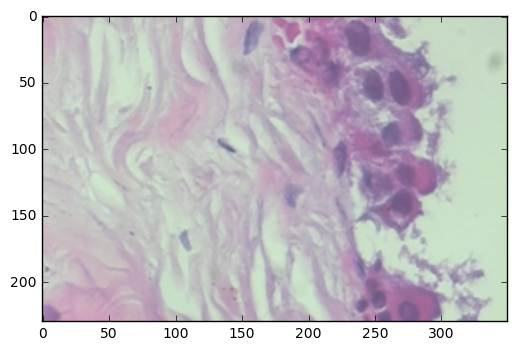

In [177]:
# A sample benign (Adenosis) image
import matplotlib.image as mpimg
image = mpimg.imread('BreasKHis_large/Benign/SOB_B_A-14-22549AB-400-001.png')
plt.imshow(image)
plt.show()


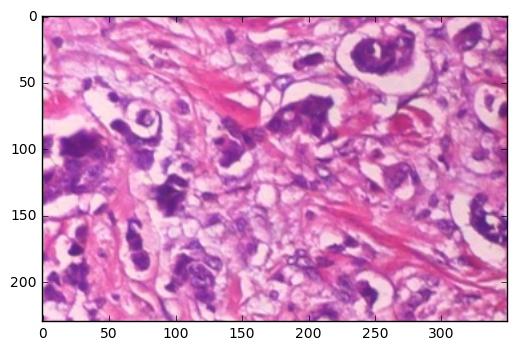

In [182]:
# A sample malignant (Ductal Carcinoma) image
import matplotlib.image as mpimg
image = mpimg.imread('BreasKHis_small/Malignant/SOB_M_DC-14-4364-400-001.png')
plt.imshow(image)
plt.show()


The original 700 by 460 images are reduced to 230 by 151 size to improve prediction accuracy [Hafemann et al.(2014)]

In [7]:

def maybe_resize(folders, resize_height, resize_width, in_channel=3):
    for folder in folders:
        image_files = os.listdir(folder)
        for image in image_files:
            image_file = os.path.join(folder, image)
            image_data = (ndimage.imread(image_file, mode='RGB')) 
            if image_data.shape == (resize_width, resize_height, in_channel):
                print ('Image size is okay - skipping resizing')
            else:
                img = Image.open(image_file)
                img.thumbnail([resize_height, resize_width], Image.ANTIALIAS)
                img.save(image_file)
                  
    return folders
train_folders = maybe_resize(train_folders, 230, 151)
test_folders = maybe_resize(test_folders, 230, 151)


Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skipping resizing
Image size is okay - skip

---
We now load and store on disk each class of the data. 
We'll convert the entire dataset into a 4D array (image index, x, y,3-RGB) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

---

In [4]:
image_width = 151  # Pixel width.
image_height = 230 # Pixel height
pixel_depth = 255.0  # Number of levels per pixel (8-bit depth).
in_channel = 3  # 3-channel RGB, 8-bit depth

def load_class(folder, min_num_images):
    """Load the data for a single tumor type."""
    
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_width, image_height, in_channel), dtype=np.float32)
    
    print(folder)
    num_images = 0
    for image in image_files: 
        image_file = os.path.join(folder,image)
        
        try: 
            image_data = (ndimage.imread(image_file, mode='RGB').astype(float) - pixel_depth / 2) / pixel_depth
            
            if image_data.shape != (image_width, image_height, in_channel):
                raise Exception('Unexpected image size: %s' % str(image_data.shape))
            dataset[num_images, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print ('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
    dataset = dataset[0:num_images, :, :]
    
    if num_images < min_num_images:
        raise Exception('Number of images are fewer than expected:' '%d < %d' % (num_images,min_num_images))
            
    print('Full dataset Tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle (data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        
        if os.path.exists(set_filename) and not force:
             print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_class(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to:', set_filename, ':', e)
    return dataset_names

train_datasets = maybe_pickle(train_folders, 10)
test_datasets = maybe_pickle(test_folders,5)
 

C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_large\Benign.pickle already present - Skipping pickling.
C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_large\Malignant.pickle already present - Skipping pickling.
C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_small\Benign.pickle already present - Skipping pickling.
C:/WorkFolder2017/AI Projects/Breast Cancer Histopathological Image\BreasKHis_small\Malignant.pickle already present - Skipping pickling.


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 7 according to the mapping: Note B = benign; M = malignant
  -  0 => Adenosis (B_A)
  -  1 => DuctalCarcinoma (M_DC)
  -  2 => Fibroadenoma (B_F)
  -  3 => LobularCarcinima (M_LC)
  -  4 => MucinousCarcinoma (M_MC)
  -  5 => PapillaryCarcinoma (M_PC)
  -  6 => PhyllodesTumor (B_PT)
  -  7 => TubularAdenoma (B_TA)

Also create a validation dataset for hyperparameter tuning.

In [5]:
def make_arrays(nb_rows, img_width, img_height, color_channel):
    if nb_rows:
        dataset = np.ndarray((nb_rows, image_width, image_height, in_channel), dtype=np.float32)
        labels = np.ndarray((nb_rows),dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels 

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    train_dataset, train_labels = make_arrays(train_size, image_height, image_width, in_channel)
    valid_dataset, valid_labels = make_arrays(valid_size, image_height, image_width, in_channel)
    valid_size_per_class = valid_size // num_classes
    train_size_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = valid_size_per_class, train_size_per_class
    end_l = valid_size_per_class+train_size_per_class
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # shuffle the letters in each pickle_file to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:valid_size_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += valid_size_per_class
                    end_v += valid_size_per_class
                
                train_letter = letter_set[valid_size_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += train_size_per_class
                end_t += train_size_per_class
        except Exception as e:
            print ('Unable to process data from', pickle_file, ':', e)
            raise
        
    return valid_dataset, valid_labels, train_dataset, train_labels,

train_size = 300
valid_size = 112
test_size = 100

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (300, 151, 230, 3) (300,)
Validation: (112, 151, 230, 3) (112,)
Testing: (100, 151, 230, 3) (100,)


Additional Visualization
------------------------

In [233]:
np.random.seed(111)
integer_labels = {0: 'B_A', 1: 'M_DC', 2: 'B_F', 3: 'M_LC',\
                  4: 'M_MC', 5: 'M_PC', 6: 'B_PT', 7: 'B_TA'}

def view_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 4)
  for i, item in enumerate(items):
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.title(integer_labels[labels[item]])
    plt.imshow(dataset[item])

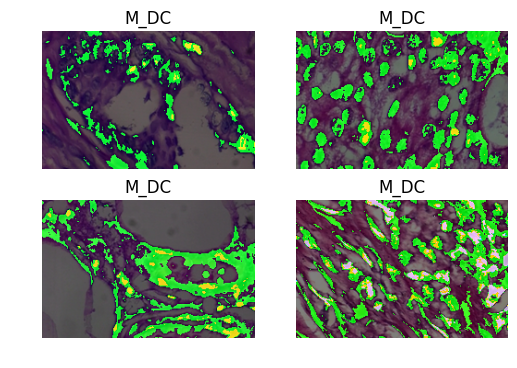

In [234]:
view_sample_dataset(train_dataset, train_labels)

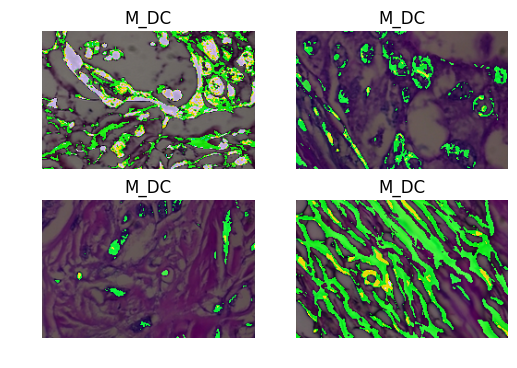

In [235]:
view_sample_dataset(valid_dataset, valid_labels)

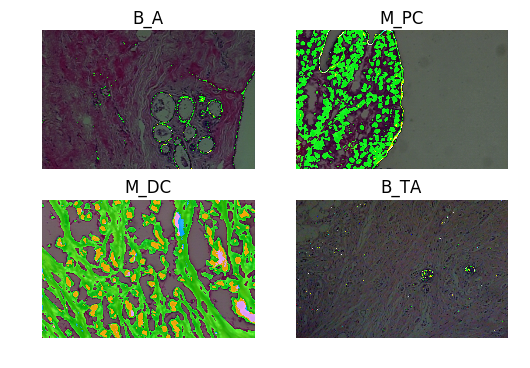

In [24]:
view_sample_dataset(test_dataset, test_labels)

The data is now randomized in order to have the labels well shuffled for the training and test distributions to match.

In [6]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

The data is saved for later reuse:

In [7]:
pickle_file = os.path.join(data_root, 'BreasKHis.pickle')

try:
   with open(pickle_file, 'wb') as f:
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [8]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 213383672


---
Removing Overlapping and Duplicate Images
-----------------------------------------
---

In [37]:
def extract_overlap(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [40]:
%time overlap_test_train = extract_overlap(test_dataset[:80], train_dataset)

Wall time: 8.52 s


In [41]:
print('Number of overlaps:', len(overlap_test_train.keys()))


Number of overlaps: 5


Sanitizing test and training data

In [42]:
def sanetize(dataset_1, dataset_2, labels_1):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = [] # list of indexes
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap.append(i) 
  return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

In [43]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset[:30], train_dataset, test_labels[:30])
print('Overlapping images removed: ', len(test_dataset[:30]) - len(test_dataset_sanit))

Wall time: 4.35 s
Overlapping images removed:  1


In [44]:
%time train_dataset_sanit, train_labels_sanit = sanetize(test_dataset, train_dataset, train_labels)
print('Overlapping images removed: ', len(train_dataset) - len(train_dataset_sanit))

Wall time: 4.2 s
Overlapping images removed:  260


In [45]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

Wall time: 4.34 s
Overlapping images removed:  4


Note: Since the dataset is small in size it suffices to use all the samples with overlaps and duplicates.

---
Training a LogisticRegression Model (using scikit-learn)
---------
---

In [260]:
from sklearn.linear_model import LogisticRegression
# Reshape training_dataset into a 2D array (# We have to reshape them because scikit-learn expects (n_samples, n_features)).
nsamples, nx, ny,col_chan = train_dataset.shape
train_dataset_2d = train_dataset.reshape((nsamples,nx*ny*col_chan))
test_dataset_2d = test_dataset.reshape((test_dataset.shape[0],nx*ny*col_chan))

y_train = train_labels
y_test = test_labels
#CreateLogReg
logit = LogisticRegression()
#Learn LogReg
logit.fit(train_dataset_2d,y_train)
logit.score(test_dataset_2d,y_test) # returns the mean accuracy on the given testdata and labels

0.75

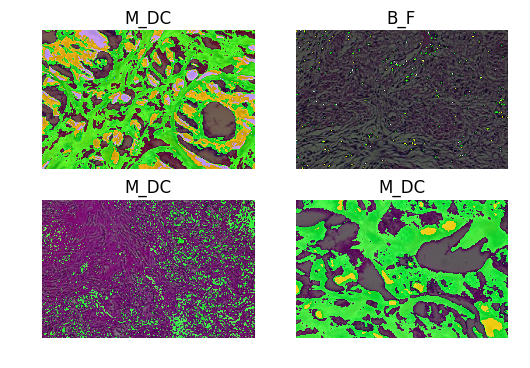

In [54]:
pred_labels = logit.predict(test_dataset_2d) # predicts class labels for test_dataset_2d
view_sample_dataset(test_dataset, pred_labels)

Reload Saved Data 
--------------

In [9]:
pickle_file  = 'BreasKHis.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # in order to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    


Training set (300, 151, 230, 3) (300,)
Validation set (112, 151, 230, 3) (112,)
Test set (100, 151, 230, 3) (100,)


Reformat Datasets/Labels to Suit Training Models (datasets as flat matrices and labels as float 1-hot encodings)
-----------------------------------------

In [10]:
image_width = 151
image_height = 230
col_chan = 3
num_classes = 2 # same as number of labels

def reformat_dataset(dataset, labels):
    dataset = dataset.reshape((len(dataset),image_width*image_height*col_chan)).astype(np.float32) 
    labels = np.arange(num_classes) == labels[:,None].astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat_dataset(train_dataset, train_labels)
valid_dataset, valid_labels = reformat_dataset(valid_dataset, valid_labels)
test_dataset, test_labels = reformat_dataset(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (300, 104190) (300, 2)
Validation set (112, 104190) (112, 2)
Test set (100, 104190) (100, 2)


TensorFlow Module
-----
Stages of Model Training (Multinomial Logistic Regression) and Comparison:
    1. using the simple gradient descent optimizer
    2. using the stochastic gradient descent (SGD) optimizer
    3. using SGD plus ReLUs
    4. using SGD plus ReLUs and Regularization

In [263]:
# Building TensorFlow Graph for # 1
train_subset = 81
graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_height * image_width * col_chan, num_classes]))
    biases = tf.Variable(tf.zeros([num_classes]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    

Estimate accuracy by:

In [14]:
def accuracy_calculator(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Computing the graph above in the following runtime code block:

In [264]:
num_steps = 801

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy_calculator(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy_calculator(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 41.920330
Training accuracy: 49.4%
Validation accuracy: 50.9%
Loss at step 100: 0.000002
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 200: 0.000001
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 300: 0.000000
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 400: 0.000000
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 500: 0.000000
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 600: 0.000000
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 700: 0.000000
Training accuracy: 100.0%
Validation accuracy: 65.2%
Loss at step 800: 0.000000
Training accuracy: 100.0%
Validation accuracy: 65.2%
Test accuracy: 78.0%


We now try SGD

In [265]:
# Building TensorFlow Graph for #2
batch_size = 70
graph = tf.Graph()
with graph.as_default():
    
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_height * image_width * col_chan))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_height * image_width * col_chan, num_classes]))
    biases = tf.Variable(tf.zeros([num_classes]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    

Computing Graph for # 2

In [266]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy_calculator(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy_calculator(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 39.549164
Minibatch accuracy: 48.6%
Validation accuracy: 49.1%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 55.4%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 57.1%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 57.1%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 57.1%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 57.1%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 57.1%
Test accuracy: 77.0%


#3 Use of ReLU to handle nonlinearity in the input data

In [12]:
# Building TensorFlow Graph for #3
batch_size = 70
num_hidden1_nodes = 20
graph = tf.Graph()
with graph.as_default():
    
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_height * image_width * col_chan))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_reg = tf.placeholder(tf.float32)
  
    # Variables.
    
    weights1 = tf.Variable(tf.truncated_normal([image_height * image_width * col_chan, num_hidden1_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden1_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden1_nodes, num_classes]))
    biases2 = tf.Variable(tf.zeros([num_classes]))
  
    # Training computation.
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=tf_train_labels, logits=logits)) + beta_reg * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [270]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy_calculator(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy_calculator(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 75.996788
Minibatch accuracy: 47.1%
Validation accuracy: 50.0%
Minibatch loss at step 500: 0.656655
Minibatch accuracy: 51.4%
Validation accuracy: 49.1%
Minibatch loss at step 1000: 0.689909
Minibatch accuracy: 40.0%
Validation accuracy: 50.0%
Minibatch loss at step 1500: 0.673883
Minibatch accuracy: 47.1%
Validation accuracy: 50.0%
Minibatch loss at step 2000: 0.665354
Minibatch accuracy: 48.6%
Validation accuracy: 49.1%
Minibatch loss at step 2500: 0.662634
Minibatch accuracy: 62.9%
Validation accuracy: 49.1%
Minibatch loss at step 3000: 0.662683
Minibatch accuracy: 54.3%
Validation accuracy: 49.1%
Test accuracy: 50.0%


Tuning Regularization Coefficient (beta)
-------------
The hyperparameter associated with the L2 regularization is tuned as follows in order to find the best beta value:

In [ ]:
# Building TensorFlow Graph for #3
batch_size = 70
num_hidden1_nodes = 20
graph = tf.Graph()
with graph.as_default():
    
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_height * image_width * col_chan))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_reg = tf.placeholder(tf.float32)
  
    # Variables.
    
    weights1 = tf.Variable(tf.truncated_normal([image_height * image_width * col_chan, num_hidden1_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden1_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden1_nodes, num_classes]))
    biases2 = tf.Variable(tf.zeros([num_classes]))
  
    # Training computation.
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=tf_train_labels, logits=logits)) + beta_reg * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [20]:
num_steps = 3001

regul_val = [pow(10, i) for i in np.arange(-3,-1, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:    
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
           
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_reg: regul}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


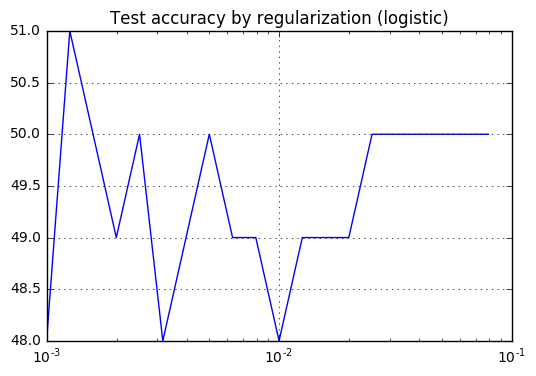

In [21]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

In [22]:
regul_val

[0.001,
 0.0012589254117941675,
 0.0015848931924611141,
 0.0019952623149688807,
 0.002511886431509582,
 0.0031622776601683824,
 0.0039810717055349778,
 0.0050118723362727298,
 0.0063095734448019424,
 0.0079432823472428294,
 0.010000000000000021,
 0.012589254117941701,
 0.015848931924611172,
 0.019952623149688851,
 0.025118864315095874,
 0.031622776601683888,
 0.039810717055349852,
 0.050118723362727401,
 0.063095734448019553,
 0.079432823472428457]

We now use the tuned beta_reg parameter to measure the effect of regularization on the prediction accuracy

In [33]:
# Building TensorFlow Graph for # 4
batch_size = 90
num_hidden1_nodes = 30
graph = tf.Graph()
with graph.as_default():
    
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_height * image_width * col_chan))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_reg = tf.placeholder(tf.float32)
  
    # Variables.
    
    weights1 = tf.Variable(tf.truncated_normal([image_height * image_width * col_chan, num_hidden1_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden1_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden1_nodes, num_classes]))
    biases2 = tf.Variable(tf.zeros([num_classes]))
  
    # Training computation.
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    beta_reg *(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [34]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_reg: 0.00126}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy_calculator(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy_calculator(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1583.149292
Minibatch accuracy: 50.0%
Validation accuracy: 50.0%
Minibatch loss at step 500: 1078.213989
Minibatch accuracy: 56.7%
Validation accuracy: 48.2%
Minibatch loss at step 1000: 574.430847
Minibatch accuracy: 55.6%
Validation accuracy: 48.2%
Minibatch loss at step 1500: 306.167023
Minibatch accuracy: 50.0%
Validation accuracy: 47.3%
Minibatch loss at step 2000: 163.379257
Minibatch accuracy: 47.8%
Validation accuracy: 49.1%
Minibatch loss at step 2500: 87.299965
Minibatch accuracy: 61.1%
Validation accuracy: 49.1%
Minibatch loss at step 3000: 46.814423
Minibatch accuracy: 44.4%
Validation accuracy: 50.0%
Test accuracy: 50.0%


ConvNets
--------
Next, we build a small network with two convolutional layers, followed by one fully connected layer. Other details of the network are: stride = 2, and a hidden layer with 64 hidden units. Bote that datasets need to be reshaped into a 4D array.

In [12]:
# Reload Saved Data

pickle_file  = 'BreasKHis.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # in order to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    


Training set (300, 151, 230, 3) (300,)
Validation set (112, 151, 230, 3) (112,)
Test set (100, 151, 230, 3) (100,)


In [13]:
# Reshaping dataset
in_channel = 3 # input layer color channel (same as 'col_chan' as used above)
image_width = 230  # Pixel width.
image_height = 151 # Pixel height
pixel_depth = 255.0  # Number of levels per pixel (8-bit depth).
num_classes = 2

def reformat_dataset(dataset, labels):
    dataset = dataset.reshape((-1, image_height,image_width, in_channel)).astype(np.float32) 
    labels = np.arange(num_classes) == labels[:,None].astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat_dataset(train_dataset, train_labels)
valid_dataset, valid_labels = reformat_dataset(valid_dataset, valid_labels)
test_dataset, test_labels = reformat_dataset(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (300, 151, 230, 3) (300, 2)
Validation set (112, 151, 230, 3) (112, 2)
Test set (100, 151, 230, 3) (100, 2)


In [4]:
batch_size = 16
patch_size = 5
out_channel = 20 # K-th depth of output layer
num_hidden = 64

graph = tf.Graph()
with graph.as_default():
    

      # Input data.
      tf_train_dataset = tf.placeholder(
      tf.float32, shape=(batch_size, image_height, image_width, in_channel))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, in_channel, out_channel], stddev=0.1)) # filter of convolution 1
      layer1_biases = tf.Variable(tf.zeros([out_channel]))
      layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, out_channel, out_channel], stddev=0.1))     # filter of convolution 2
      layer2_biases = tf.Variable(tf.constant(1.0, shape=[out_channel]))
      layer3_weights = tf.Variable(tf.truncated_normal(
          [round(image_height / 4) * round(image_width / 4) * out_channel, num_hidden], stddev=0.1))
      layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
      layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_classes], stddev=0.1))
      layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_classes]))

      # Model.
      def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

      # Training computation.
      logits = model(tf_train_dataset)
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
      test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [315]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy_calculator(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy_calculator(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1.858150
Minibatch accuracy: 50.0%
Validation accuracy: 50.0%
Minibatch loss at step 500: 0.860757
Minibatch accuracy: 62.5%
Validation accuracy: 50.0%
Minibatch loss at step 1000: 0.912372
Minibatch accuracy: 56.2%
Validation accuracy: 50.0%
Minibatch loss at step 1500: 0.693836
Minibatch accuracy: 50.0%
Validation accuracy: 50.0%
Minibatch loss at step 2000: 0.700390
Minibatch accuracy: 43.8%
Validation accuracy: 50.0%
Minibatch loss at step 2500: 0.721358
Minibatch accuracy: 62.5%
Validation accuracy: 50.0%
Minibatch loss at step 3000: 0.760083
Minibatch accuracy: 43.8%
Validation accuracy: 50.0%
Test accuracy: 50.0%


A pooling operation is now used to reduce feature maps spatial dimensions. Thus, we replace the stride approach used in the previous model with a max pooling operation of stride 2 and kernel size 2.

In [14]:
batch_size = 16
patch_size = 15
out_channel = 20 # K-th depth of output layer
in_channel = 3 # input layer color channel (same as 'col_chan' as used above)
num_hidden = 64

graph = tf.Graph()
with graph.as_default():
    
    # Input Data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, in_channel))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    lay1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, in_channel, out_channel], stddev=0.1))                           
    lay1_biases = tf.Variable(tf.zeros([out_channel]))
    lay2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, out_channel, out_channel], stddev=0.1))
    lay2_biases = tf.Variable(tf.constant(1.0, shape=[out_channel]))
    lay3_weights = tf.Variable(tf.truncated_normal([round(image_height / 4) * round(image_width / 4) * out_channel,
                                                    num_hidden], stddev=0.1))
    lay3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    lay4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_classes], stddev=0.1))
    lay4_biases = tf.Variable(tf.constant(1.0, shape=[num_classes])) 
    
    # Define a Function for the Convolutional Model
    def model (data):
        conv = tf.nn.conv2d(data, lay1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + lay1_biases)
        pool= tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, lay2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + lay2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, lay3_weights) + lay3_biases)
        
        return tf.matmul(hidden, lay4_weights) + lay4_biases
    
    # Training Computations
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Prediction Computations
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy_calculator(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy_calculator(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy_calculator(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.708902
Minibatch accuracy: 50.0%


In [2]:
from math import sqrt

def put_kernels_on_grid (kernel, pad = 1):

  '''Visualize conv. filters as an image (mostly for the 1st layer).
  Arranges filters into a grid, with some paddings between adjacent filters.
  Args:
    kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
    pad:               number of black pixels around each filter (between them)
  Return:
    Tensor of shape [1, (Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels].
  '''
  # get shape of the grid. NumKernels == grid_Y * grid_X
  def factorization(n):
    for i in range(int(sqrt(float(n))), 0, -1):
      if n % i == 0:
        if i == 1: print('Who would enter a prime number of filters')
        return (i, int(n / i))
  (grid_Y, grid_X) = factorization (kernel.get_shape()[3].value)
  print ('grid: %d = (%d, %d)' % (kernel.get_shape()[3].value, grid_Y, grid_X))

  x_min = tf.reduce_min(kernel)
  x_max = tf.reduce_max(kernel)
  kernel = (kernel - x_min) / (x_max - x_min)

  # pad X and Y
  x = tf.pad(kernel, tf.constant( [[pad,pad],[pad, pad],[0,0],[0,0]] ), mode = 'CONSTANT')

  # X and Y dimensions, w.r.t. padding
  Y = kernel.get_shape()[0] + 2 * pad
  X = kernel.get_shape()[1] + 2 * pad

  channels = kernel.get_shape()[2]

  # put NumKernels to the 1st dimension
  x = tf.transpose(x, (3, 0, 1, 2))
  # organize grid on Y axis
  x = tf.reshape(x, tf.stack([grid_X, Y * grid_Y, X, channels]))

  # switch X and Y axes
  x = tf.transpose(x, (0, 2, 1, 3))
  # organize grid on X axis
  x = tf.reshape(x, tf.stack([1, X * grid_X, Y * grid_Y, channels]))

  # back to normal order (not combining with the next step for clarity)
  x = tf.transpose(x, (2, 1, 3, 0))

  # to tf.image_summary order [batch_size, height, width, channels],
  #   where in this case batch_size == 1
  x = tf.transpose(x, (3, 0, 1, 2))

  # scaling to [0, 255] is not necessary for tensorboard
  return x


#
# ... and somewhere inside "def train():" after calling "inference()"
#

# Visualize conv1 kernels
with tf.variable_scope('conv'):
  tf.get_variable_scope().reuse_variables()
  weights = tf.get_variable('weights')
  grid = put_kernels_on_grid (weights)
  tf.image.summary('conv1/kernels', grid, max_outputs=1)

ValueError: Variable conv/weights does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?